# Imports

In [33]:
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

In [34]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)
import zScore
import sexToBinary as sb
import wScore

# Set Directory Paths

In [35]:
# Directory path to load formatted Pathology Data
%store -r path_dataDir
# Directory path to load formatted Thickness Data
%store -r thick_dataDir
# Directory path to load formatted Thickness At Path Data
%store -r thickAtPath_dataDir
# Directory path to save Calcualted Analysis Data
%store -r thickAtPath_CalData
# Directory path to save Figures
%store -r thickAtPath_Fig

%store -r path_CalData

# Loading

## Loading Center of Mass of Regions (in this case it is CoM of Pathology regions)

In [36]:
with open(os.path.join(path_dataDir, 'pathCoM.pkl'), 'rb') as f:
    pathCoM = pickle.load(f)
f.close()

## Loading Raw Thickness/Volume Data

In [37]:
# HCResults
with open(os.path.join(thick_dataDir, 'HCResults.pkl'), 'rb') as f:
    HCResults = pickle.load(f)
f.close()

# PatientTAUResults
with open(os.path.join(thick_dataDir, 'PatientTAUResults.pkl'), 'rb') as f:
    PatientTAUResults = pickle.load(f)
f.close()

# PatientTDPResults
with open(os.path.join(thick_dataDir, 'PatientTDPResults.pkl'), 'rb') as f:
    PatientTDPResults = pickle.load(f)
f.close()

## Loading Thickness Values at Pathology Regions

In [38]:
# HCthicknessAtPath
with open(os.path.join(thickAtPath_dataDir, 'HCthicknessAtPath.pkl'), 'rb') as f:
    HCthicknessAtPath = pickle.load(f)
f.close()

# TAUthicknessAtPath
with open(os.path.join(thickAtPath_dataDir, 'TAUthicknessAtPath.pkl'), 'rb') as f:
    TAUthicknessAtPath = pickle.load(f)
f.close()

# TDPthicknessAtPath
with open(os.path.join(thickAtPath_dataDir, 'TDPthicknessAtPath.pkl'), 'rb') as f:
    TDPthicknessAtPath = pickle.load(f)
f.close()

In [39]:
# Sanity Check
assert(HCthicknessAtPath.shape == (54, 40))
assert(TAUthicknessAtPath.shape == (26, 40))
assert(TDPthicknessAtPath.shape == (30, 40))

## Loading Volume Values at Pathology Regions

In [40]:
# HCVolumeAtPath
with open(os.path.join(thickAtPath_dataDir, 'HCVolumeAtPath.pkl'), 'rb') as f:
    HCVolumeAtPath = pickle.load(f)
f.close()

# TAUVolumeAtPath
with open(os.path.join(thickAtPath_dataDir, 'TAUVolumeAtPath.pkl'), 'rb') as f:
    TAUVolumeAtPath = pickle.load(f)
f.close()

# TDPVolumeAtPath
with open(os.path.join(thickAtPath_dataDir, 'TDPVolumeAtPath.pkl'), 'rb') as f:
    TDPVolumeAtPath = pickle.load(f)
f.close()

In [41]:
# Sanity Check
assert(HCVolumeAtPath.shape == (54, 40))
assert(TAUVolumeAtPath.shape == (26, 40))
assert(TDPVolumeAtPath.shape == (30, 40))

In [42]:
with open(os.path.join(path_CalData, 'LabelNames.pkl'), 'rb') as f:
    LabelNames = pickle.load(f)
f.close()

In [43]:
LabelNames

array(['ANG_L', 'ATC_L', 'HIP_L', 'IFC_L', 'M1_L', 'MFC_L', 'OFC_L',
       'PC_L', 'S1_L', 'SMTC_L', 'SPC_L', 'V1_L', 'aCING_L', 'aINS_L',
       'aITC_L', 'dlPFC_L', 'iPFC_L', 'mPFC_L', 'pCING_L', 'pSTC_L',
       'ANG_R', 'ATC_R', 'HIP_R', 'IFC_R', 'M1_R', 'MFC_R', 'OFC_R',
       'PC_R', 'S1_R', 'SMTC_R', 'SPC_R', 'V1_R', 'aCING_R', 'aINS_R',
       'aITC_R', 'dlPFC_R', 'iPFC_R', 'mPFC_R', 'pCING_R', 'pSTC_R'],
      dtype=object)

# Formatting Data / Defining Variable

## Convert PathCoM to appropriate shape: 20 x 3 x 2 --> 40 x 3

In [44]:
pathCoM = np.vstack((pathCoM[:, :, 0], pathCoM[:, :, 1]))

## N = Number of regions we are analyzing for Thickness at Path

In [45]:
N = pathCoM.shape[0]
assert(N == 40)

# Calculating Z Score

## Z Score for Thickness Values

In [46]:
HCthicknessAtPath_z, TAUthicknessAtPath_z, TDPthicknessAtPath_z = zScore.generateZScore(HCthicknessAtPath, 
                                                                                        TAUthicknessAtPath, 
                                                                                        TDPthicknessAtPath)

## Z Score for Volume Values

In [47]:
HCVolumeAtPath_z, TAUVolumeAtPath_z, TDPVolumeAtPath_z = zScore.generateZScore(HCVolumeAtPath, 
                                                                               TAUVolumeAtPath, 
                                                                               TDPVolumeAtPath)

# Calculating W Score

## Parameters: Age, Sex, and ICV

## Get Age Values

In [48]:
# List of 54, 26, and 30 Denoting Age
ageHC = HCResults['Age'].reshape((-1, 1)) # (54,1)
ageTAU = PatientTAUResults['Age'].reshape((-1, 1)) # (26,1)
ageTDP = PatientTDPResults['Age'].reshape((-1, 1)) # (30,1)

assert(ageHC.shape == (HCthicknessAtPath.shape[0],1))
assert(ageTAU.shape == (TAUthicknessAtPath.shape[0],1))
assert(ageTDP.shape == (TDPthicknessAtPath.shape[0],1))

## Get Sex Values

In [49]:
# List of 54, 26, and 30 Denoting Sex
sexHC = HCResults['Sex'] # (54,1)
sexTAU = PatientTAUResults['Sex'] # (26,1)
sexTDP = PatientTDPResults['Sex'] # (30,1)

# Convert Male --> 0 / Female --> 1
sexHC = np.array(sb.sexToBinary(sexHC)).reshape((-1, 1)) #  (54,1)
sexTAU = np.array(sb.sexToBinary(sexTAU)).reshape((-1, 1)) #  (26,1)
sexTDP = np.array(sb.sexToBinary(sexTDP)).reshape((-1, 1)) #  (30,1)

assert(sexHC.shape == (HCthicknessAtPath.shape[0],1))
assert(sexTAU.shape == (TAUthicknessAtPath.shape[0],1))
assert(sexTDP.shape == (TDPthicknessAtPath.shape[0],1))

## Get ICV Values

In [50]:
icvHC = HCResults['Volume']['ICV'].reshape((-1, 1)) # (54,1)
icvTAU = PatientTAUResults['Volume']['ICV'].reshape((-1, 1)) # (26,1)
icvTDP = PatientTDPResults['Volume']['ICV'].reshape((-1, 1)) # (30,1)

assert(icvHC.shape == (HCthicknessAtPath.shape[0],1))
assert(icvTAU.shape == (TAUthicknessAtPath.shape[0],1))
assert(icvTDP.shape == (TDPthicknessAtPath.shape[0],1))

## Stack Age, Sex, and ICV values

In [51]:
# Stack the Age and Sex features into 2D array
hcCov = np.concatenate((ageHC, sexHC, icvHC), axis=1) # (54, 3)
tauCov = np.concatenate((ageTAU, sexTAU, icvTAU), axis=1)  # (26, 3)
tdpCov = np.concatenate((ageTDP, sexTDP, icvTDP), axis=1) # (30, 3)

assert(hcCov.shape == (HCthicknessAtPath.shape[0], 3))
assert(tauCov.shape == (TAUthicknessAtPath.shape[0], 3))
assert(tdpCov.shape == (TDPthicknessAtPath.shape[0], 3))

## Calculating W Score for Thickness Values

In [52]:
# Get W score for thickness values
HCthicknessAtPath_w, TAUthicknessAtPath_w, TDPthicknessAtPath_w = wScore.generateWScore(hcCov, tauCov, tdpCov, N, 
                                                                                        HCthicknessAtPath, 
                                                                                        TAUthicknessAtPath, 
                                                                                        TDPthicknessAtPath)

## Calculating W Score for Volume Values

In [53]:
# Get W score for thickness values
HCVolumeAtPath_w, TAUVolumeAtPath_w, TDPVolumeAtPath_w = wScore.generateWScore(hcCov, tauCov, tdpCov, N, 
                                                                               HCVolumeAtPath, 
                                                                               TAUVolumeAtPath, 
                                                                               TDPVolumeAtPath)

# Dataset Distribution Comparison

In [54]:
def dist_boxplot(data, labels, min_val, max_val, title, x_label, y_label):
    # Reorder the data and labels (group by regions L, R)
    new_order = [i//2 if i % 2 == 0 else int((i//2) + (len(labels)/2)) for i in range(len(labels))]
    reordered_data = data[:, new_order]
    reordered_labels = [labels[i] for i in new_order]
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create boxplots for each column
    boxplot = sns.boxplot(data=reordered_data, width=0.5, ax=ax, fliersize=0, boxprops=dict(alpha=.3))

    # Add individual data points with aligned x-values
    for i, col_data in enumerate(reordered_data.T):
        # Handle NaNs
        col_data = col_data[~np.isnan(col_data)]

        jitter = np.random.normal(0, 0.1, size=len(col_data))  # Add jitter for better visualization
        x = np.full_like(col_data, i) + jitter
        ax.scatter(x, col_data, alpha=0.5, color='blue', s=5)

     # Add vertical lines every two columns
    for i in range(1, int(len(labels)-2), 2):
        ax.axvline(x=i + 0.5, color='grey', linestyle='--', lw=0.5)
        
    # Set x-axis labels
    ax.set_xticks(np.arange(0, len(labels)))
    ax.set_xticklabels(reordered_labels, rotation=45, ha='right')  # Use NeuN_Labels as x-axis labels

    # Set y-axis limits (replace these values with your desired limits)
    y_min_limit = min_val  # Minimum limit
    y_max_limit = max_val  # Maximum limit
    ax.set_ylim(y_min_limit, y_max_limit)

    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show the plot
    plt.tight_layout()
    plt.show()

## Original Volume Measurements

In [55]:
# min max
all_values = np.concatenate([HCVolumeAtPath.flatten(), TAUVolumeAtPath.flatten(), TDPVolumeAtPath.flatten()])
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
buffer = (max_val-min_val) * 0.1

min_val = min_val - buffer
max_val = max_val + buffer

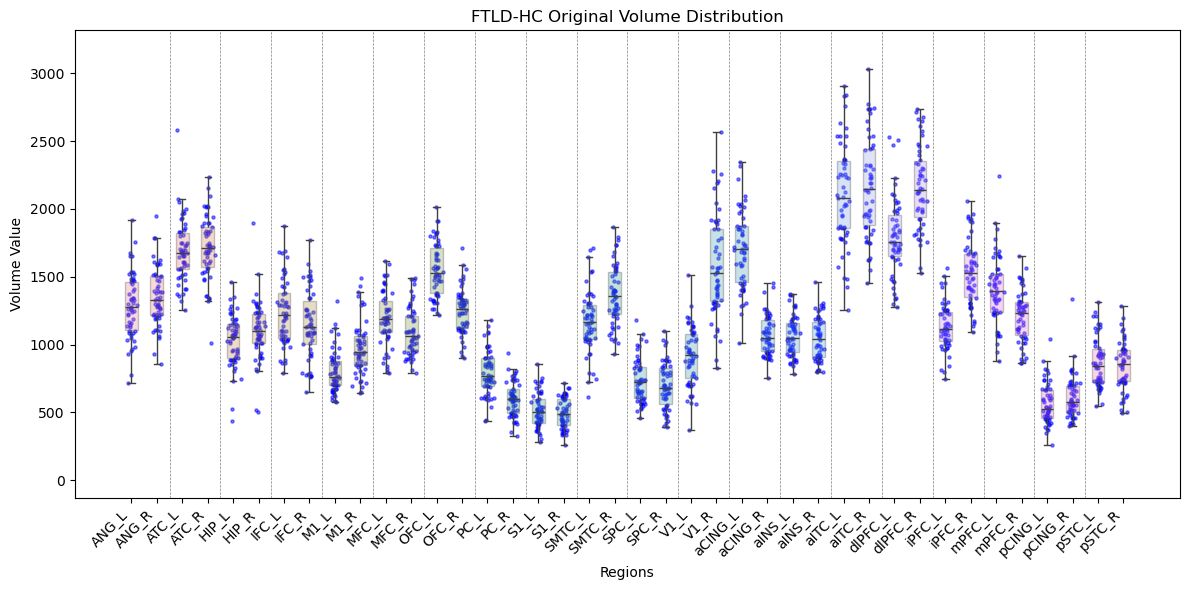

In [56]:
dist_boxplot(HCVolumeAtPath, LabelNames, min_val, max_val, 'FTLD-HC Original Volume Distribution', 'Regions', 'Volume Value')

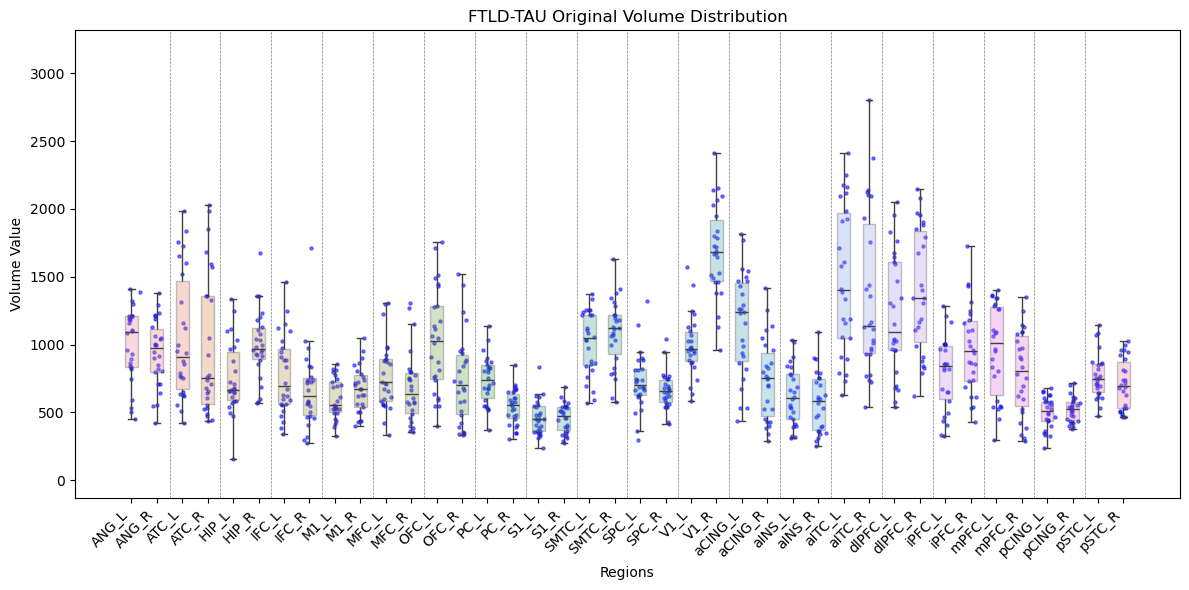

In [57]:
dist_boxplot(TAUVolumeAtPath, LabelNames, min_val, max_val, 'FTLD-TAU Original Volume Distribution', 'Regions', 'Volume Value')

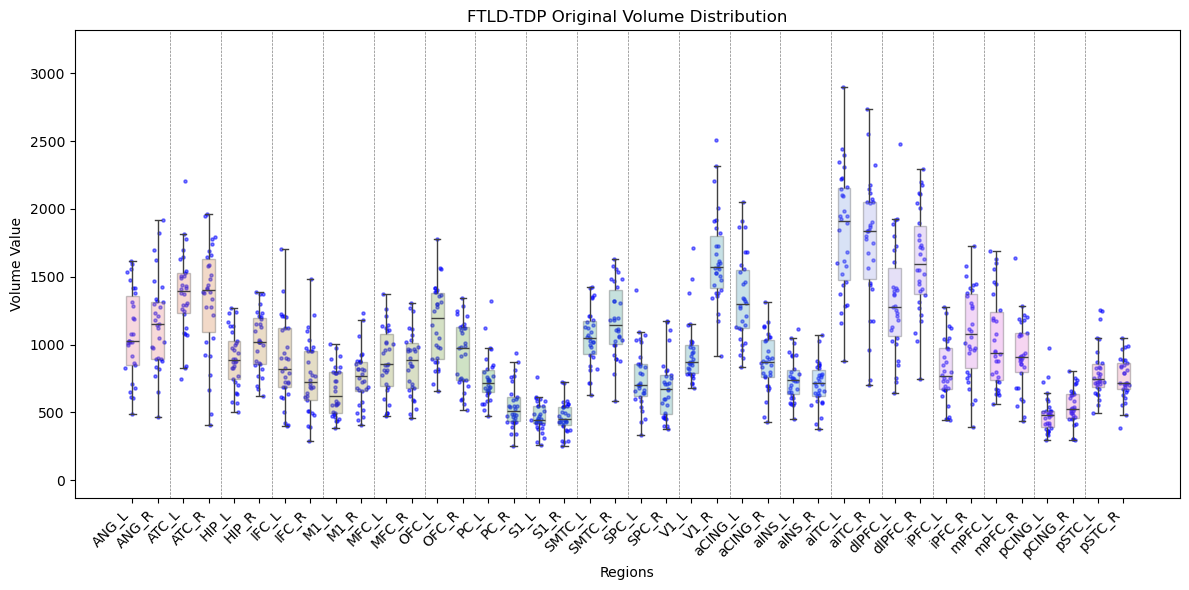

In [58]:
dist_boxplot(TDPVolumeAtPath, LabelNames, min_val, max_val, 'FTLD-TDP Original Volume Distribution', 'Regions', 'Volume Value')

## W-Score Volume Measurements

In [59]:
# min max
all_values = np.concatenate([HCVolumeAtPath_w.flatten(), TAUVolumeAtPath_w.flatten(), TDPVolumeAtPath_w.flatten()])
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
buffer = (max_val-min_val) * 0.1

min_val = min_val - buffer
max_val = max_val + buffer

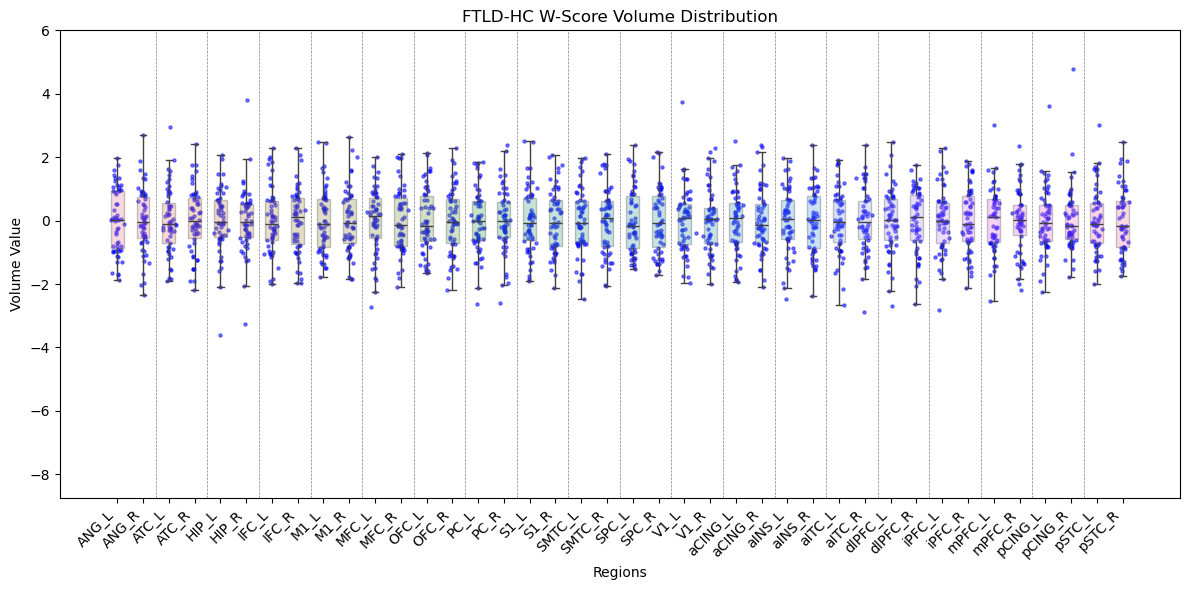

In [60]:
dist_boxplot(HCVolumeAtPath_w, LabelNames, min_val, max_val, 'FTLD-HC W-Score Volume Distribution', 'Regions', 'Volume Value')

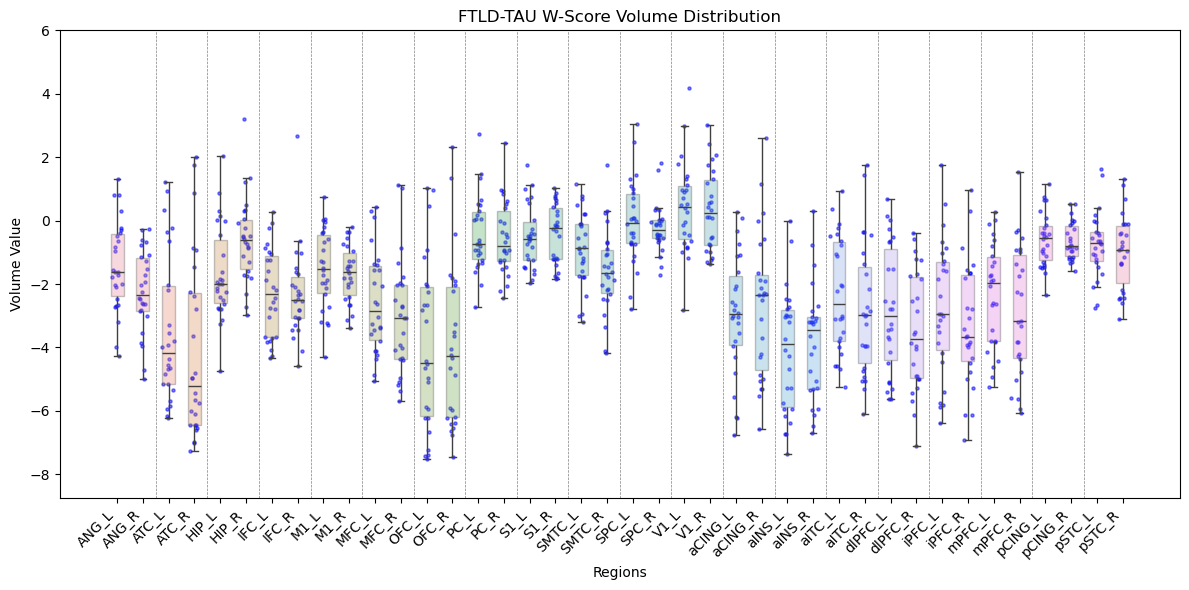

In [61]:
dist_boxplot(TAUVolumeAtPath_w, LabelNames, min_val, max_val, 'FTLD-TAU W-Score Volume Distribution', 'Regions', 'Volume Value')

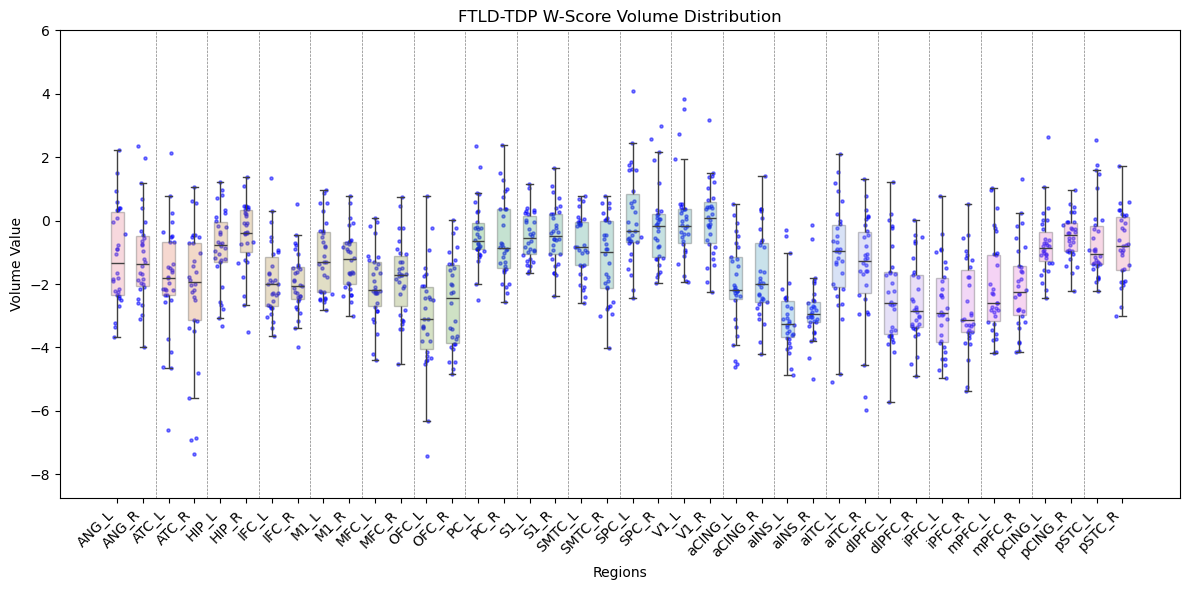

In [62]:
dist_boxplot(TDPVolumeAtPath_w, LabelNames, min_val, max_val, 'FTLD-TDP W-Score Volume Distribution', 'Regions', 'Volume Value')

# Saving

## Save Calculated Z Scores

In [63]:
# HCthicknessAtPath_z
with open(os.path.join(thickAtPath_CalData, 'HCthicknessAtPath_z.pkl'), 'wb') as f:
    pickle.dump(HCthicknessAtPath_z, f)
f.close()

# TAUthicknessAtPath_z
with open(os.path.join(thickAtPath_CalData, 'TAUthicknessAtPath_z.pkl'), 'wb') as f:
    pickle.dump(TAUthicknessAtPath_z, f)
f.close()

# TDPthicknessAtPath_z
with open(os.path.join(thickAtPath_CalData, 'TDPthicknessAtPath_z.pkl'), 'wb') as f:
    pickle.dump(TDPthicknessAtPath_z, f)
f.close()

#-----

# HCVolumeAtPath_z
with open(os.path.join(thickAtPath_CalData, 'HCVolumeAtPath_z.pkl'), 'wb') as f:
    pickle.dump(HCVolumeAtPath_z, f)
f.close()

# TAUVolumeAtPath_z
with open(os.path.join(thickAtPath_CalData, 'TAUVolumeAtPath_z.pkl'), 'wb') as f:
    pickle.dump(TAUVolumeAtPath_z, f)
f.close()

# TDPVolumeAtPath_z
with open(os.path.join(thickAtPath_CalData, 'TDPVolumeAtPath_z.pkl'), 'wb') as f:
    pickle.dump(TDPVolumeAtPath_z, f)
f.close()

## Save Calcuated W Scores

In [64]:
# HCthicknessAtPath_w
with open(os.path.join(thickAtPath_CalData, 'HCthicknessAtPath_w.pkl'), 'wb') as f:
    pickle.dump(HCthicknessAtPath_w, f)
f.close()

# TAUthicknessAtPath_w
with open(os.path.join(thickAtPath_CalData, 'TAUthicknessAtPath_w.pkl'), 'wb') as f:
    pickle.dump(TAUthicknessAtPath_w, f)
f.close()

# TDPthicknessAtPath_w
with open(os.path.join(thickAtPath_CalData, 'TDPthicknessAtPath_w.pkl'), 'wb') as f:
    pickle.dump(TDPthicknessAtPath_w, f)
f.close()

#-----

# HCVolumeAtPath_w
with open(os.path.join(thickAtPath_CalData, 'HCVolumeAtPath_w.pkl'), 'wb') as f:
    pickle.dump(HCVolumeAtPath_w, f)
f.close()

# TAUVolumeAtPath_w
with open(os.path.join(thickAtPath_CalData, 'TAUVolumeAtPath_w.pkl'), 'wb') as f:
    pickle.dump(TAUVolumeAtPath_w, f)
f.close()

# TDPVolumeAtPath_w
with open(os.path.join(thickAtPath_CalData, 'TDPVolumeAtPath_w.pkl'), 'wb') as f:
    pickle.dump(TDPVolumeAtPath_w, f)
f.close()